### Building chtbot with multiple tools with Langgraph

### Aim
Create a chatbot with tool capabilities from arxiv, wikipedia and some custom functions.

In [4]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [5]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [6]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [8]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(wiki.name)

wikipedia


In [9]:
wiki.invoke("What is a pasta?")

'Page: Pasta\nSummary: Pasta (UK: , US: ; Italian: [ˈpasta]) is a type of food typically made from an unleavened dough of wheat flour mixed with water or eggs, and formed into sheets or other shapes, then cooked by boiling or baking. Pasta was originally only made with durum, although the definition has been expanded to include alternatives for a gluten-free diet, such as rice flour, or legumes such as beans or lentils. Pasta is believed to have developed independently in Italy and is a staple foo'

In [12]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [16]:
### load Tavily search tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

In [17]:
tavily.invoke("Hey, provide me current FIFA club world cup news.")

[{'title': 'FIFA Club World Cup News, Stats, Scores - ESPN',
  'url': 'https://www.espn.com/soccer/league/_/name/fifa.cwc',
  'content': '| Group A | GP | W | D | L | GD | P |\n| --- | --- | --- | --- | --- | --- | --- |\n| Palmeiras | 3 | 1 | 2 | 0 | +2 | 5 |\n| Inter Miami CF | 3 | 1 | 2 | 0 | +1 | 5 |\n| FC Porto | 3 | 0 | 2 | 1 | -1 | 2 |\n| Al Ahly | 3 | 0 | 2 | 1 | -2 | 2 |\n| Group B | GP | W | D | L | GD | P |\n| --- | --- | --- | --- | --- | --- | --- |\n| Paris Saint-Germain | 3 | 2 | 0 | 1 | +5 | 6 |\n| Botafogo | 3 | 2 | 0 | 1 | +1 | 6 |\n| Atlético Madrid | 3 | 2 | 0 | 1 | -1 | 6 | [...] | Fluminense | 3 | 1 | 2 | 0 | +2 | 5 |\n| Mamelodi Sundowns | 3 | 1 | 1 | 1 | 0 | 4 |\n| Ulsan HD | 3 | 0 | 0 | 3 | -4 | 0 |\n| Group G | GP | W | D | L | GD | P |\n| --- | --- | --- | --- | --- | --- | --- |\n| Manchester City | 3 | 3 | 0 | 0 | +11 | 9 |\n| Juventus | 3 | 2 | 0 | 1 | +5 | 6 |\n| Al Ain | 3 | 1 | 0 | 2 | -10 | 3 |\n| Wydad AC | 3 | 0 | 0 | 3 | -6 | 0 |\n| Group H | GP | W

In [18]:
### COmbine all tools

tools=[arxiv, wiki, tavily]

In [23]:
## Initialize my LLM model

from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen/qwen3-32b")
llm_with_tools=llm.bind_tools(tools)

In [27]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

response=llm_with_tools.invoke([HumanMessage(content=f"Who is the current FIFA club world cup champion?")])

# Use pprint to explore the response object
pprint(response)

# If the model decided to call tools, they will be inside `tool_calls`
if hasattr(response, "tool_calls"):
    print("\nTool calls:")
    pprint(response.tool_calls)
else:
    print("\nNo tool calls made.")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking who the current FIFA Club World Cup champion is. I need to figure out the most up-to-date information. First, I should check if I have any functions that can provide this information. The available tools are arxiv, wikipedia, and tavily_search_results_json.\n\nThe arxiv function is for academic papers, which probably isn\'t relevant here. Wikipedia might have historical data, but maybe not the latest results. The tavily_search_results_json seems like a search engine that can fetch recent information. \n\nSo, I should use tavily_search_results_json with a query like "current FIFA Club World Cup champion" or "2023 FIFA Club World Cup winner". That should give the latest champion. Let me make sure the query is specific enough. The user wants the current one, so including the year might help. But maybe the search function can handle it without the year. \n\nAlternatively, checking the most recent data u

In [28]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]
    

In [33]:
### Entire CHatbot With Laggraph

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}


#Build graph
builder= StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)

graph = builder.compile()

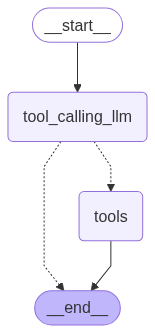

In [34]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
## invocation

messages=graph.invoke({"messages":"What is latest transfer news on Man utd"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is lateest transfer news on Man utd
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (zj2t4j88g)
 Call ID: zj2t4j88g
  Args:
    query: latest Manchester United transfer news
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Manchester United need two transfers to confirm vital agreement for ...", "url": "https://www.manchestereveningnews.co.uk/sport/football/transfer-news/manchester-united-need-two-transfers-32050144", "content": "Manchester Evening News\n\n# Manchester United need two transfers to confirm vital agreement for Bryan Mbeumo transfer\n\n## Latest Manchester United transfer news and gossip as another club's business may affect United's chances of signing Bryan Mbeumo\n\nBryan Mbeumo of Brentford is a target for Manchester United\n\nManches

In [36]:
## invocation

messages=graph.invoke({"messages":"give some info on Harry Potter"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

give some info on Harry Potter
================================== Ai Message ==================================
Tool Calls:
  wikipedia (fe90y91gv)
 Call ID: fe90y91gv
  Args:
    query: Harry Potter
================================= Tool Message =================================
Name: wikipedia

Page: Harry Potter
Summary: Harry Potter is a series of seven fantasy novels written by British author J. K. Rowling. The novels chronicle the lives of a young wizard, Harry Potter, and his friends, Ron Weasley and Hermione Granger, all of whom are students at Hogwarts School of Witchcraft and Wizardry. The main story arc concerns Harry's conflict with Lord Voldemort, a dark wizard who intends to become immortal, overthrow the wizard governing body known as the Ministry of Magic, and subjugate a


In [ ]:
## invocation

messages=graph.invoke({"messages":"High Energy Physics"})

for message in messages["messages"]:
    message.pretty_print()